# Comparison of results obtained with greatpy and great 

This notebook allows to test all the bed files present in "../../data/tests/test_data/input/"  

For each file the function returns a scatterplot allowing the comparison between the binomial and hypergeometric p-value of greatpy vs great, the pearson coefficient for each of these representations. 

The function also returns the number of good gene-peak associations, the number of gene-peak associations "forgotten" by greatpy and the number of gene-peak associations that should not be selected. 


Finally the function returns the shape of the df before and after preprocessing in order to know how many GO terms have been lost because they were not selected by greatpy. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import greatpy as great
import pandas as pd
from math import inf
from numpy import log,nan, int64,cov,corrcoef
from scipy.stats import pearsonr
import os 
import re

import warnings
warnings.filterwarnings('ignore')

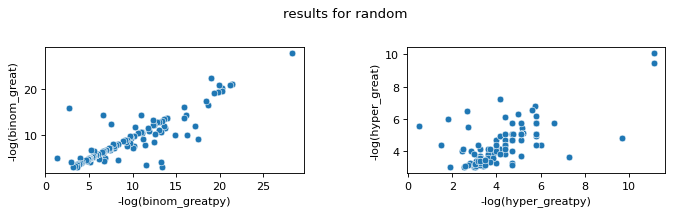

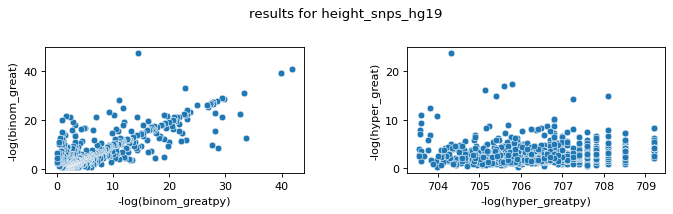

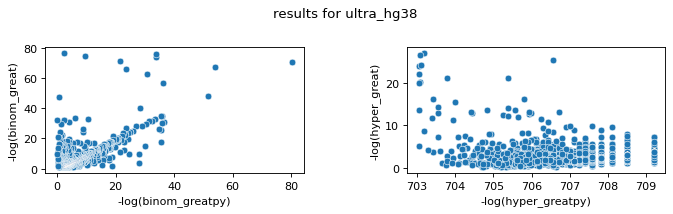

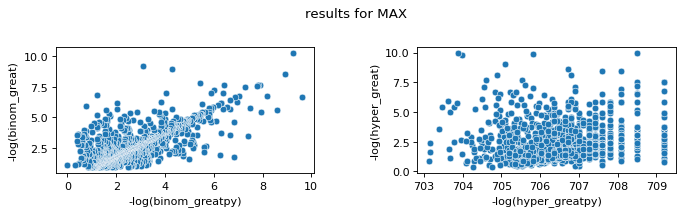

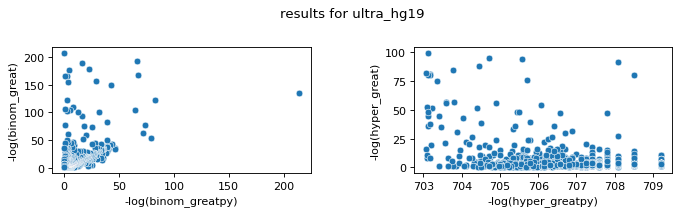

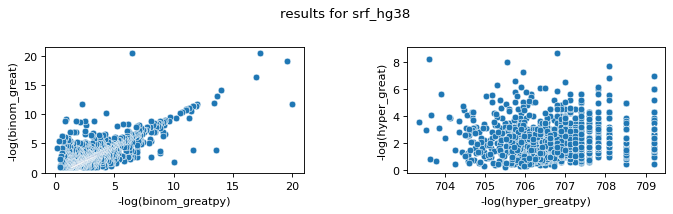

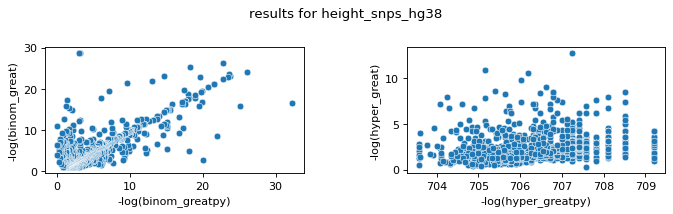

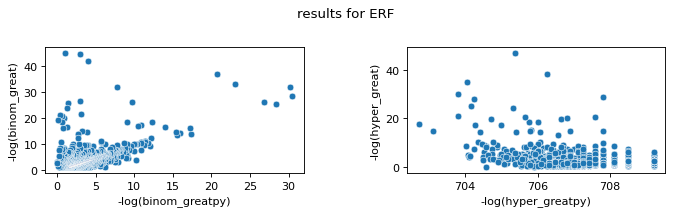

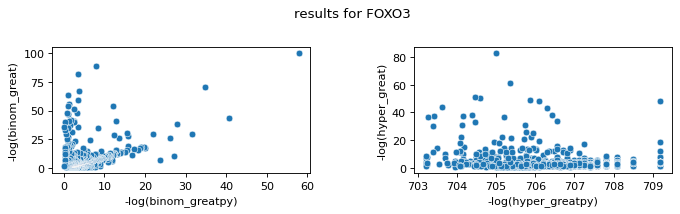

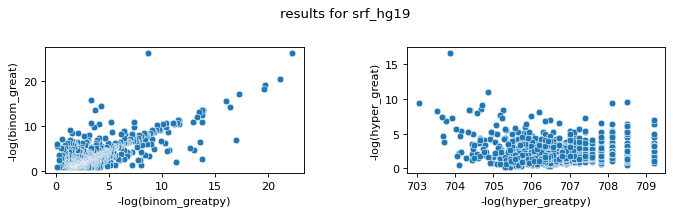

In [3]:
import os 
import re
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter

def all_comparison(preprocessing:bool=True,good_gene_associations:bool=True,disp_scatterplot:bool=True,stats:bool=True): 
    pp = {
        "name":[],
        "before_pp_greatpy_size":[], 
        "before_pp_great_size":[],
        "final_size":[],
        "%_of_GO_from_great_lost":[],
    }
    asso = {
        "name":[],
        "number_good_gene_asso":[],
        "number_genes_asso_lost":[],
        "number_gene_asso_excess":[],
    }

    stat_df = {
        "name" : [],
        "pearson_binom": [], 
        "pearson_hypergeom": []
    }

    nb = len(os.listdir("../../data/tests/test_data/input/"))
    for path in os.listdir("../../data/tests/test_data/input/") : 
        sp = path.split(".")
        id = sp[0][:2]
        name = sp[0][3:]
        pp["name"].append(name)
        i = 0
        great_out = ""
        great_asso = ""

        for out_path in os.listdir("../../data/tests/test_data/output/") :
            if out_path.split("_")[0] == id : 
                if re.match(".*hg19.*",out_path) != None : 
                    assembly = "hg19"
                else : 
                    assembly = "hg38"
                
                if re.match(".*output.*",out_path) != None : 
                    great_out = "../../data/tests/test_data/output/" + out_path
                else : 
                    great_asso = "../../data/tests/test_data/output/" + out_path 

        test = "../../data/tests/test_data/input/" + path 
        regdom = f"../../data/human/{assembly}/regulatory_domain.bed"
        size = f"../../data/human/{assembly}/chr_size.bed"

        if great_out == "" or great_asso == "" : 
            return False
        
        enrichment_tot = great.tl.GREAT.enrichment(test_file=test,
                                                    regdom_file=regdom,
                                                    chr_size_file=size,
                                                    annotation_file=f"../../data/human/ontologies.csv",
                                                    binom=True,
                                                    hypergeom=True,
                                                    )
        enrichment_tot = great.tl.GREAT.set_bonferroni(enrichment_tot,0.05)
        enrichment_tot = great.tl.GREAT.set_fdr(enrichment_tot,0.05)
            
        great_webserver = pd.read_csv(great_out,sep="\t",comment="#",
                                    names=["ontologie","term_name","ID","binom_p_value","binom_bonferroni","binom_fdr","hyper_p_value","hyper_bonferroni","hyper_fdr"],index_col=False,
                                    dtype={"term_name":"object", "ID":"object","binom_p_value":"float64", "binom_bonferroni":"float64", "binom_fdr":"float64", "hyper_p_value":"float64", "hyper_bonferroni":"float64", "hyper_fdr":"float64"})
        great_webserver.rename(columns={"ID":"id"},inplace=True)
        del great_webserver["ontologie"]
        del great_webserver["term_name"]
        
        pp["before_pp_greatpy_size"].append(enrichment_tot.shape[0])
        enrichment_tot = enrichment_tot[enrichment_tot.index.isin(list(great_webserver["id"]))]
        pp["final_size"].append(enrichment_tot.shape[0])

        pp["before_pp_great_size"].append(great_webserver.shape[0])
        pp["%_of_GO_from_great_lost"].append(round(((great_webserver.shape[0] - enrichment_tot.shape[0])/great_webserver.shape[0])*100,2))
        great_webserver = great_webserver[great_webserver["id"].isin(list(enrichment_tot.index))]

        great_webserver = great_webserver.sort_values("id")

        if disp_scatterplot or stats:
            binom_greatpy = []
            hyper_greatpy = []
            binom_great = []
            hyper_great = []
            for i in range(enrichment_tot.shape[0]) : 
                go_id = list(enrichment_tot.index)[i]
                curr_enrichment = enrichment_tot.iloc[i]
                curr_great_webserver = great_webserver.loc[great_webserver["id"]==go_id]
                binom_greatpy.append(float(curr_enrichment["binom_p_value"]))
                hyper_greatpy.append(float(curr_enrichment["hypergeom_p_value"]))
                binom_great.append(float(curr_great_webserver["binom_p_value"]))
                hyper_great.append(float(curr_great_webserver["hyper_p_value"]))
            binom = pd.DataFrame({"binom_greatpy":binom_greatpy,"binom_great":binom_great})
            hyper = pd.DataFrame({"hyper_greatpy":hyper_greatpy,"hyper_great":hyper_great})

            if disp_scatterplot : 
                fig = plt.figure(figsize=(10,5),dpi=80)
                fig.subplots_adjust(hspace=0.4, wspace=0.4)
                ax = fig.add_subplot(2, 2, 1)
                great.pl.scatterplot(binom,colname_x="binom_greatpy",colname_y="binom_great",title=None,ax = ax)
                ax = fig.add_subplot(2, 2, 2)
                great.pl.scatterplot(hyper,colname_x="hyper_greatpy",colname_y="hyper_great",title=None,ax = ax)
                fig.suptitle(f"results for {name}")
                plt.show()
                # great.pl.scatterplot(binom,colname_x="binom_greatpy",colname_y="binom_great",title=f"binom comparison for {name}")
                # great.pl.scatterplot(hyper,colname_x="hyper_greatpy",colname_y="hyper_great",title=f"hypergeom comparison for {name}")
            if stats : 
                stat_df["name"].append(name)
                stat_df["pearson_binom"].append(pearsonr(binom_great,binom_greatpy)[0])
                stat_df["pearson_hypergeom"].append(pearsonr(hyper_great,hyper_greatpy)[0])
            
        
        if good_gene_associations :         
            gene_asso_great = pd.read_csv(great_asso,sep="\t",comment="#",names=["ontologies","gene"],index_col=False, dtype={"ontologies":"object","gene":"object"},usecols=["gene"])
            gene_asso_greatpy = great.tl.get_association(
                test = pd.read_csv(test,sep="\t",comment="#",usecols=[0,1,2],names=["Chr", "Chr_Start", "Chr_End"],dtype={"Chr":"object", "Chr_Start":"int64", "Chr_End":"int64"}),
                regdom= pd.read_csv(regdom,sep="\t",comment="#",names=["Chr", "Chr_Start", "Chr_End","Name","tss","Strand"],dtype={"Chr":"object", "Chr_Start":"int64", "Chr_End":"int64","Name":"object","tss":"int64","Strand":"object"})
                )
            

            in_in = gene_asso_great[gene_asso_great["gene"].isin(gene_asso_greatpy)].shape[0]
            in_out = [i for i in list(gene_asso_great["gene"]) if i not in gene_asso_greatpy]
            out_in = [i for i in gene_asso_greatpy if i not in list(gene_asso_great["gene"])]

            asso["name"].append(name)
            asso["number_good_gene_asso"].append(str(in_in))
            asso["number_genes_asso_lost"].append(str(len(in_out)))
            asso["number_gene_asso_excess"].append(str(len(out_in))) 

        # nb-=1
        # print(f"{name} finished, still {nb} more files to calculate") 
        # enrichment_tot = pd.DataFrame()
    if stat_df : 
        stat_df = pd.DataFrame(stat_df)

    return pd.DataFrame(pp), pd.DataFrame(asso), stat_df 
pp,asso,stat = all_comparison()

Note 40 min of computation time 

## Let the pearson coefficient between the p-value determined by greatpy and great for each file name 

In [4]:
stat

,name,pearson_binom,pearson_hypergeom
0,random,2.40765e-01,1.24707e-01
1,height_snps_hg19,4.96919e-01,1.22609e-01
2,ultra_hg38,5.29490e-01,1.78085e-02
3,MAX,5.98854e-01,1.45437e-01
4,ultra_hg19,4.60618e-01,-1.49227e-02
5,srf_hg38,6.31909e-01,9.35986e-02
6,height_snps_hg38,4.91711e-01,2.93823e-01
7,ERF,5.46607e-01,-1.15524e-01
8,FOXO3,4.31749e-01,-4.37002e-02
9,srf_hg19,6.28616e-01,-8.96150e-03


Here we observe a weak correlation for the binomial p-value, there is no correlation between the hypergeometric p-values. 

Remark: if the value of the hypergeometric p-value is too low (<e-308) it is fixed at e-308, which explains the stacked points on the right of the scatter plot. 

## So for each file the reduction operated between greatpy and great. 

This reduction is linked to the fact that some GOs returned are not present in greatpy AND great 

In [11]:
pp

,name,before_pp_greatpy_size,before_pp_great_size,final_size,%_of_GO_from_great_lost
0,random,581,197,117,4.10000e+01
1,height_snps_hg19,2299,2063,1167,4.30000e+01
2,ultra_hg38,3267,2175,1393,3.60000e+01
3,MAX,3013,2395,1482,3.80000e+01
4,ultra_hg19,3034,2186,1363,3.80000e+01
5,srf_hg38,4819,2681,1854,3.10000e+01
6,height_snps_hg38,2287,2103,1141,4.60000e+01
7,ERF,6045,2410,1837,2.40000e+01
8,FOXO3,2810,2328,1346,4.20000e+01
9,srf_hg19,4162,2063,1464,2.90000e+01


Note: The size of after_pp_greatpy_size should be close or equal to before_pp_great_size. 

## Either the number of good gene-peaks, the number of "forgotten" associations, and the number of "excess" associations compared to great 

In [6]:
asso

,name,number_good_gene_asso,number_genes_asso_lost,number_gene_asso_excess
0,random,57,0,1
1,height_snps_hg19,287,0,0
2,ultra_hg38,496,0,2
3,MAX,428,0,4
4,ultra_hg19,480,0,3
5,srf_hg38,923,0,7
6,height_snps_hg38,277,0,1
7,ERF,1456,0,36
8,FOXO3,400,0,8
9,srf_hg19,791,0,3


Note : The 4 forgotten gene for ultra_hg19 have been solved thanks to currated regions, the code has just not been after this modification yet.

Here we see that some genes have been selected "in excess" (<1%). But I do not understand because my associations seem, my regdom file seems also good because it is identical to the one in "/storage/groups/ml01/datasets/annotations/hg19/regDom.out"